# Excercise - Multi-class classification of MNIST using Perceptron

In binary perceptron, where $\mathbf{y} \in \{-1, +1\}$, we used to update our weights only for wrongly classified examples.

The multi-class perceptron is regarded as a generalization of binary perceptron. Learning through iteration is the same as the perceptron. Weighted inputs are passed through a multiclass signum activation function. If the predicted output label is the same as true label then weights are not updated. However, when predicted output label $\neq$ true label, then the wrongly classified input example is added to the weights of the correct label and subtracted from the weights of the incorrect label. Effectively, this amounts to ’rewarding’ the correct weight vector, ’punishing’ the misleading, incorrect weight
vector, and leaving alone an other weight vectors.

# Load the utils notebook

In [1]:
!pip3 install -U gif

  Using cached https://files.pythonhosted.org/packages/30/bf/92385b4262178ca22b34f82e0e09c2922eb351fe39f3cc7b8ba9ea555b41/Pillow-7.2.0-cp36-cp36m-manylinux1_x86_64.whl


# Import modules

I have imported some functions from utils, that is the only change made

In [2]:
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
import math
import gif
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting the seed to ensure reproducibility of experiments
# np.random.seed(11)

# One-hot encoding of target label, Y
def one_hot(a):
  b = -1 * np.ones((a.size, a.max()+1))
  b[np.arange(a.size), a] = 1
  return b

# Loading digits datasets
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
Y = one_hot(Y)

# Adding column of ones to absorb bias b of the hyperplane into X
X = digits.data
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

In [4]:
# Train-val-test data
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1257, 65)
Validation dataset:  (180, 65)
Test dataset:  (360, 65)


<Figure size 640x480 with 0 Axes>

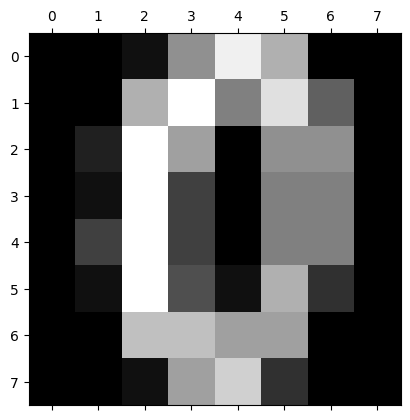

In [5]:
sns.reset_orig();

# print(digits.data[:20])
# print(digits.target[:20])

plt.gray()
plt.matshow(digits.images[10])
plt.show();

# Utility Functions

We use some functions defined in the earlier - utils.py notebook. 
Notably, we use the multi class signum function which helps us train 10 perceptrons at once.

In [6]:
# multi-class signum
def multi_class_signum(vec_w_x):
  """ Multiclass signum activation.

  Parameters
  ------------
  vec_w_x: ndarray
    Weighted inputs
  """

  flag = np.all(vec_w_x == 0)

  if flag:
    return vec_w_x

  else:
    num_examples, num_outputs = np.shape(vec_w_x)
    range_examples = np.array(range(0, num_examples))

    zero_idxs = np.argwhere(np.all(vec_w_x == 0, axis=1))
    non_zero_examples = np.delete(range_examples, zero_idxs[:, 0])
      
    signum_vec_w_x = vec_w_x[non_zero_examples]
    maxvals = np.amax(signum_vec_w_x, axis=1)
    
    for i in range(num_examples):
      idx = np.argwhere(signum_vec_w_x == maxvals[i])[0]
      signum_vec_w_x[idx[0], idx[1]] = 1

    non_maxvals_idxs = np.argwhere(signum_vec_w_x != 1)
    signum_vec_w_x[non_maxvals_idxs[:, 0], non_maxvals_idxs[:, 1]] = -1
    vec_w_x[non_zero_examples] = signum_vec_w_x

    return vec_w_x

In [7]:
# Evaluation for train, val, and test set.
def get_accuracy(y_predicted, Y_input_set, num_datapoints):
  miscls_points = np.argwhere(np.any(y_predicted != Y_input_set, axis=1))
  miscls_points = np.unique(miscls_points)
  accuracy = (1-len(miscls_points)/num_datapoints)*100
  return accuracy

def get_prediction(X_input_set, Y_input_set, weights, get_acc=False, model_type='perceptron', predict='no'):

  if len(Y_input_set) != 0:
    num_datapoints, num_categories = np.shape(Y_input_set)

  vec_w_transpose_x = np.dot(X_input_set, weights)

  if num_categories > 1: # Multi-class
    if model_type == 'perceptron':
      y_pred_out = multi_class_signum(vec_w_transpose_x)
    elif model_type == 'logreg':
      y_pred_out = softmax(X_input_set, vec_w_transpose_x, predict=predict)

  else: # Binary class
    if model_type == 'perceptron' or model_type == 'LinearDA':
      y_pred_out = signum(vec_w_transpose_x)
    elif model_type == 'logreg':
      y_pred_out = sigmoid(vec_w_transpose_x, predict=predict)

  # Both prediction and evaluation
  if get_acc:
    cls_acc = get_accuracy(y_pred_out, Y_input_set, num_datapoints)
    return cls_acc, y_pred_out
  
  # Only prediction
  return y_pred_out

# Train

We train a set of perceptrons simultaneously here, using the multi_class_signum function.

In [8]:
# Perceptron training algorithm
def train(X_train, Y_train, weights, learning_rate=1, total_epochs=100):
    """Training method for Perceptron.

    Parameters
    -----------

    X_train: ndarray (num_examples(rows) vs num_features(columns))
    Input dataset which perceptron will use to learn optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels for input data

    weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

    learning_rate: int
    Learning rate use to learn and update weights

    total_epochs: int
    Max number of epochs to train the perceptron model
    """

    n_samples, _ = np.shape(X_train)
    history_weights = []
    epoch = 1

    # Number of missclassified points we would like to see in the train set.
    # While training, its value will change every epoch. If m==0, our training 
    # error will be zero.
    m = 1

    # If the most recent weights gave 0 misclassifications, break the loop.
    # Else continue until total_epochs is completed.
    while m != 0 and epoch <= total_epochs:
        m = 0
        
        # Compute weighted inputs and predict class labels on training set.
        weights_transpose_x = multi_class_signum(X_train @ weights)
        y_train_out = np.multiply(Y_train, weights_transpose_x)
        epoch += 1

        # Collecting misclassified indexes and count them
        y_miscls_idxs = np.argwhere(y_train_out <= 0)[:, 0]
        y_miscls_idxs = np.unique(y_miscls_idxs)
        m = len(y_miscls_idxs)

        # Calculate gradients and update weights
        dweights = (X_train[y_miscls_idxs]).T @ Y_train[y_miscls_idxs]
        weights += (learning_rate/n_samples) * dweights

        # Append weights to visualize decision boundary later
        history_weights.append(weights)

    if epoch < total_epochs:
        print("Training has stabilized with all points classified: ", epoch)
    else:
        print(f'Training completed at {epoch-1} epochs. {m} misclassified points remain.')

    return history_weights

In [9]:
# Initializing weights to zero
_, n_features = np.shape(X_train)
_, n_outputs = np.shape(Y_train)

weights = np.zeros((n_features, n_outputs))

In [10]:
trained_weights = train(X_train, Y_train, weights, learning_rate=0.05, total_epochs=100)

Training completed at 100 epochs. 53 misclassified points remain.


In [11]:
best_weights = trained_weights[-1]

train_acc, _ = get_prediction(X_train, Y_train, best_weights, get_acc=True)
val_acc, _ = get_prediction(X_val, Y_val, best_weights, get_acc=True)
test_acc, _ = get_prediction(X_test, Y_test, best_weights, get_acc=True)

print("Evaluation results")
print("Training accuracy: {:.3f}" .format(train_acc))
print("Validation accuracy: {:.3f}" .format(val_acc))
print("Test accuracy: {:.3f}" .format(test_acc))

Evaluation results
Training accuracy: 95.465
Validation accuracy: 96.667
Test accuracy: 91.667
